# PRÉPARATION DES DONNÉES

# Inspection des données

In [1]:
# Importation des librairies nécessaires :
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, f1_score, recall_score, precision_score, make_scorer, roc_curve, auc
from scipy import interp
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from statistics import mean

In [5]:
import warnings
warnings.filterwarnings('ignore')

Avant de pouvoir lancer nos modèles de prédiction de Valeur foncière, nous procédons avant tout à l'inspection des données et récupérons les fichiers.

In [6]:
# Chargement des datasets :
df1 = pd.read_csv("./assets/data/valeursfoncieres-2018.txt",sep="|")
df2 = pd.read_csv("./assets/data/valeursfoncieres-2019.txt",sep="|")
df3 = pd.read_csv("./assets/data/valeursfoncieres-2020.txt",sep="|")
df4 = pd.read_csv("./assets/data/valeursfoncieres-2021.txt",sep="|")

# Agrégation des datasets :
df_complet = pd.concat([df1,df2,df3,df4], axis=0, ignore_index=True)

In [7]:
df_complet.head()

,Identifiant de document,Reference document,1 Articles CGI,2 Articles CGI,3 Articles CGI,4 Articles CGI,5 Articles CGI,No disposition,Date mutation,Nature mutation,...,Surface Carrez du 5eme lot,Nombre de lots,Code type local,Type local,Identifiant local,Surface reelle bati,Nombre pieces principales,Nature culture,Nature culture speciale,Surface terrain
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,03/01/2018,Vente,...,NaN,2,2.0,Appartement,NaN,73.0,4.0,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,03/01/2018,Vente,...,NaN,1,3.0,Dépendance,NaN,0.0,0.0,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,04/01/2018,Vente,...,NaN,0,1.0,Maison,NaN,163.0,4.0,S,NaN,949.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,04/01/2018,Vente,...,NaN,0,1.0,Maison,NaN,163.0,4.0,AG,JARD,420.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,04/01/2018,Vente,...,NaN,0,1.0,Maison,NaN,51.0,2.0,AG,JARD,420.0


On remarque qu'il y a beaucoup de valeurs manquantes. Il sera donc nécessaire de nettoyer les données.

In [8]:
# Inspection du dataset complet :
# Dimensions du dataset :
print('Voici les dimensions du dataset complet :', df_complet.shape) # 15,125,102 observations, 43 variables

Voici les dimensions du dataset complet : (15125102, 43)


Le dataset complet contient 15 125 102 observations, et 43 variables.

# Nettoyage des données

Après avoir inspecté les données, nous procédons au nettoyage de celles-ci.

In [9]:
# Drop des duplicats :
df_complet.shape # 15,125,102 observations, 43 variables
df = df_complet.drop_duplicates(["Date mutation","Code departement","Code commune","Code voie"],keep=False)
print("Après élimination des duplicats, le nombre d'observations se réduit à 3 738 104", df.shape) # 3,738,104 observations, 43 variables

# Le fait d'éliminer les duplicats pour les variables "Date mutation", "Code département", "Code commune"
# et "Code voie" réduit considérablement les données exploitables (environ 1/5 des données exploitables).

Après élimination des duplicats, le nombre d'observations se réduit à 3 738 104 (3738104, 43)


Nous inspectons les valeurs manquantes.

In [10]:
# Détection des valeurs manquantes pour chaque variable en les sommant :
missing_data = df.isna().sum()
#missing_data

On remarque que beaucoup de variables ont un taux de valeurs manquantes supérieur ou égal à 80%.

In [11]:
# Pourcentage de valeurs manquantes pour chaque variable :
percentage_md = (missing_data / len(df)) * 100
percentage_md

Identifiant de document       100.000000
Reference document            100.000000
1 Articles CGI                100.000000
2 Articles CGI                100.000000
3 Articles CGI                100.000000
4 Articles CGI                100.000000
5 Articles CGI                100.000000
No disposition                  0.000000
Date mutation                   0.000000
Nature mutation                 0.000000
Valeur fonciere                 0.504614
No voie                        33.782928
B/T/Q                          95.666546
Type de voie                   34.565839
Code voie                       0.248013
Voie                            0.250127
Code postal                     0.252374
Commune                         0.000000
Code departement                0.000000
Code commune                    0.000000
Prefixe de section             95.573772
Section                         0.003478
No plan                         0.000000
No Volume                      99.765041
1er lot         

Nous décidons donc d'éliminer les variables pour lesquelles le taux de valeurs manquantes excède ou est égal à 80%.

In [13]:
# Drop des variables dont les valeurs manquantes excèdent les 80% :
for colonne in df :
    if (percentage_md[colonne] > 80):
        df.drop(colonne, axis=1, inplace=True)

Après filtrations des valeurs manquantes, les données sont réduites.

In [14]:
# Vérification des dimensions du dataset après filtrage des NaN :
print('Après filtrage global des valeurs manquantes, il reste 22 variables :', df.shape) # 3,738,104 observations, 22 variables restantes

# Dataset reformaté sans les NaN de 'Type local' :
df_Type = df.dropna(subset=['Type local'])
print('Après avoir filtré les valeurs manquantes de Type local, les données sont réduites à 2 342 692 :', df_Type.shape) # 2,342,692 observations, 22 variables

Après filtrage global des valeurs manquantes, il reste 22 variables : (3738104, 22)
Après avoir filtré les valeurs manquantes de Type local, les données sont réduites à 2 342 692 : (2342692, 22)


Nous reformatons Valeur foncière en variable quantitative en remplaçant les "," par des ".".

In [15]:
# Reformatage de Valeur foncière en variable quantitative :
print(df_Type['Valeur fonciere'].dtypes) # object
df_Type['Valeur fonciere'] = df_Type['Valeur fonciere'].astype(str).str.replace(",", ".").astype(float)
#print(df_Type['Valeur fonciere'])

# Vérification du type de Valeur foncière :
print(df_Type['Valeur fonciere'].dtypes) # float64

object
float64


Cela nous permet ensuite d'éliminer les valeurs aberrantes de Valeur foncière (i.e., inférieure à 1 ou NaN).

In [16]:
# Drop de Valeur foncière =< 1 et Valeur foncière != NaN :
print('Avant filtrage des valeurs aberrantes de Valeur foncière :', df_Type.shape) # 2,342,692 observations, 22 variables
df_Type = df_Type[(df_Type["Valeur fonciere"] > 1) & (df_Type["Valeur fonciere"].notna())]
print('Après filtrage des valeurs aberrantes de Valeur foncière :', df_Type.shape) # 2,337,078 observations, 22 variables

Avant filtrage des valeurs aberrantes de Valeur foncière : (2342692, 22)
Après filtrage des valeurs aberrantes de Valeur foncière : (2337078, 22)


Nous éliminons ensuite les outliers restant de Valeur foncière.

Nous définissions d'abord les premier et troisième quartile. Nous calculons l'écart interquartile afin d'obtenir les bornes inférieure et supérieure d'exclusion des outliers. Et nous les éliminons selons ces critères.

In [17]:
# Drop des outliers :

# Définit les premier et troisième quartiles :
Q1 = df_Type['Valeur fonciere'].quantile(0.25)
Q3 = df_Type['Valeur fonciere'].quantile(0.75)
print('Premier quartile :', Q1) # 85,000
print('Troisième quartile :', Q3) # 250,000

# Écart interquartile :
IQR = Q3 - Q1
print('Écart interquartile :', IQR) # 165,000

# Définit les bornes d'exclusion des outliers :
outliers_bas = Q1 - (1.5 * IQR)
outliers_haut = Q3 + (1.5 * IQR)
print("Borne inférieure d'exclusion :", outliers_bas) # 162,500
print("Borne supérieure d'exclusion :", outliers_haut) # 497,500

# Nouveau dataset (sans outliers) :
print('Dataset avant exclusion des outliers :', df_Type.shape) # 2,337,078 observations, 22 variables
df_clean = df_Type[(df_Type['Valeur fonciere'] < Q3 + (1.5 * IQR)) & (df_Type['Valeur fonciere'] > Q1 - (1.5 * IQR))]
print('Dataset après exclusion des outliers :', df_clean.shape) # 2,204,117 observations, 22 variables

Premier quartile : 85000.0
Troisième quartile : 250000.0
Écart interquartile : 165000.0
Borne inférieure d'exclusion : -162500.0
Borne supérieure d'exclusion : 497500.0
Dataset avant exclusion des outliers : (2337078, 22)
Dataset après exclusion des outliers : (2204117, 22)


Nous décidons de nous concentrer essentiellement sur les ventes (cf. variable "Nature mutation"), ce qui réduit encore le nombre de données exploitables.

In [18]:
# Sélection des ventes uniquement (cf. Nature mutation) :
df_clean = df_clean[df_clean["Nature mutation"]=="Vente"]
print('Dataset après filtrage des ventes :', df_clean.shape) # 2,166,999 observations, 22 variables

Dataset après filtrage des ventes : (2166999, 22)


La variable "Date mutation" n'étant pas intéressante pour nos modèles de prédiction, nous décidons de l'éliminer.

In [19]:
# Dataset reformaté sans Date mutation :
df_clean = df_clean.drop(columns="Date mutation")
print('Nombre de variables après exclusion de Date mutation :', df_clean.shape) # 2,166,999 observations, 21 variables

Nombre de variables après exclusion de Date mutation : (2166999, 21)


Nous devons ensuite reformater les variables "Code departement" et "Code voie" en variables catégorielles.

In [20]:
# Reformatage de Code département et Code voie en chaîne de caractères :
df_clean["Code departement"] = df_clean["Code departement"].astype(str)
df_clean["Code voie"] = df_clean["Code voie"].astype(str)

# Vérification du reformatage :
df_clean[['Code departement', 'Code voie']].dtypes # object

Code departement    object
Code voie           object
dtype: object

Nous remplaçons les valeurs manquantes des variables quantitatives par leurs moyennes. Et nous vérifions qu'il ne reste plus de valeurs manquantes dans les variables quantitatives.

In [21]:
# Remplacement des NaN des variables quantitatives par leur moyenne :
for col in df_clean.select_dtypes(exclude="object"):
    df_clean[col] = df_clean[col].fillna(df_clean[col].mean())

# Vérification du remplacement des NaN :
print('Nombre de valeurs manquantes :', df_clean.select_dtypes(exclude='object').isna().sum()) # 0 NaN

Nombre de valeurs manquantes : No disposition               0
Valeur fonciere              0
No voie                      0
Code postal                  0
Code commune                 0
No plan                      0
Nombre de lots               0
Code type local              0
Surface reelle bati          0
Nombre pieces principales    0
Surface terrain              0
dtype: int64


Nous décidons de ne garder que les variables où il n'y a plus de valeurs manquantes.

In [22]:
# Drop des NaN :
df_test = df_clean.dropna(axis=1)
print("Sur 21 variables, il n'en reste donc plus que 16 :", df_test.shape) # 2,166,999 observations, 16 variables
print('Voici la liste des variables restantes :', df_test.columns) # 1er lot et Nature culture droped

Sur 21 variables, il n'en reste donc plus que 16 : (2166999, 16)
Voici la liste des variables restantes : Index(['No disposition', 'Nature mutation', 'Valeur fonciere', 'No voie',
       'Code voie', 'Code postal', 'Commune', 'Code departement',
       'Code commune', 'No plan', 'Nombre de lots', 'Code type local',
       'Type local', 'Surface reelle bati', 'Nombre pieces principales',
       'Surface terrain'],
      dtype='object')


In [ ]:
# Remplacement des NaN des variables catégorielles par leur mode :

# Récupération des noms des variables catégorielles :
#print(df_clean.select_dtypes('object').columns)
# Instanciation de ces variables dans une variable :
#var_qual = ['Date mutation', 'Nature mutation', 'Type de voie', 'Code voie', 'Voie', 'Commune', 'Code departement',
        #'Section', '1er lot', 'Type local', 'Nature culture']
# Création d'un df pour les variables catégorielles :
#df_qual = df_clean[var_qual]
#print(df_qual)

# Remplacement des NaN des variables catégorielles par leur mode :
#df_NA1 = df_qual['Type de voie'].fillna(df_qual['Type de voie'].mode()) # Ne fonctionne pas : pas de remplacement des NaN

# Vérification du nombre de NaN des variables catégorielles :
#print(df_NA1.isnull().sum())

Nous recodons les variables catégorielles afin de pouvoir mener des analyses dessus.

In [24]:
# Recodage des variables catégorielles :
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

for col in df_test.select_dtypes('object'):
    df_test[col] = encoder.fit_transform(df_test[col])

# Sélection des variables intéressantes

Après avoir inspecté et nettoyé les données, nous devons à présent sélectionner les variables que nous utiliserons pour nos modèles de prédiction.

Nous standardisons toutes les variables quantitatives (hormis Valeur foncière et Code commune) afin de les ramener à la même échelle.

In [25]:
# Standardise les variables :
from sklearn.preprocessing import StandardScaler
df_scaler = df_test.drop(columns=["Valeur fonciere", "Code commune"])
scaler = StandardScaler()
df_scaler = scaler.fit_transform(df_scaler)
print(df_scaler)

[[-1.07332415e-01  0.00000000e+00 -3.19938578e-01 ... -1.67267150e-01
  -1.08153345e+00 -1.14396476e-16]
 [-1.07332415e-01  0.00000000e+00 -3.23504615e-01 ... -6.35267702e-02
  -2.44257818e-02 -1.14396476e-16]
 [-1.07332415e-01  0.00000000e+00 -3.20957446e-01 ... -9.40135493e-03
  -2.44257818e-02 -4.95831366e-01]
 ...
 [-1.07332415e-01  0.00000000e+00 -3.21976313e-01 ... -2.03350760e-01
  -5.52979618e-01 -1.14396476e-16]
 [-1.07332415e-01  0.00000000e+00 -3.22995181e-01 ... -3.70237457e-01
  -1.61008729e+00 -1.14396476e-16]
 [-1.07332415e-01  0.00000000e+00 -3.10768769e-01 ... -3.70237457e-01
  -1.61008729e+00 -1.14396476e-16]]


Nous lançons une régression Lasso afin de déterminer quelles variables pèsent le plus sur Valeur foncière. Ici, nous affichons ces variables lorsque leurs coefficients dépassent un certain seuil.

In [26]:
# LASSO pour sélectionner les variables :
from sklearn.linear_model import Lasso
import numpy as np
lasso = Lasso(alpha=1.0)
lasso.fit(df_scaler, df_test["Valeur fonciere"])

selected_features = np.where(lasso.coef_ >1 )[0]

Xframe = df_test.drop(columns=["Valeur fonciere","Code commune"])

print("Selected Features:")
for feature_index in selected_features:
    print(f"Feature {feature_index}: {Xframe.columns[feature_index]}")

Selected Features:
Feature 3: Code voie
Feature 4: Code postal
Feature 5: Commune
Feature 6: Code departement
Feature 7: No plan
Feature 8: Nombre de lots
Feature 9: Code type local
Feature 10: Type local
Feature 11: Surface reelle bati
Feature 12: Nombre pieces principales
Feature 13: Surface terrain


Nous affichons ensuite les 10 variables les plus importantes parmi celles sélectionnées précédemment.

In [27]:
# Sélection des 10 variables les plus importantes selon LASSO :
top_10_feature_indices = np.argsort(np.abs(lasso.coef_))[-10:]
top_10_feature_indices = [Xframe.columns[i] for i in top_10_feature_indices]
for feature in top_10_feature_indices:
    print(feature)

Commune
No voie
Code departement
Surface reelle bati
Code voie
Nombre de lots
Code postal
Code type local
Type local
Nombre pieces principales


In [28]:
# Drop des outliers :
print(df_test.shape)
top_10_feature_indices.append("Valeur fonciere")
for col in top_10_feature_indices:
    Q1 = df_test[col].quantile(0.25)
    Q3 = df_test[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_boop = df_test[(df_test[col] >= lower_bound) & (df_test[col] <= upper_bound)]
print(df_boop.shape)

(2166999, 16)
(2138139, 16)


Maintenant que les données ont été inspectées et nettoyées, et que les variables les plus importantes ont été mises en exergue, nous pouvons passer aux modèles de prédiction.

# DATAFRAME SANS TRANSFORMATIONS

Nous récupérons un dataset sans transformation des données afin de pouvoir lancer nos modèles de prédiction (cf. le split train-test ne peut être lancé sur des données préalablement transformées).

In [29]:
# Reprise du dataframe avant transformations des données :
print('df_Type :', df_Type.shape) # 2,337,078 observations, 22 variables

# Sélection des ventes uniquement (cf. Nature mutation) :
df_reg = df_Type[df_Type["Nature mutation"]=="Vente"]
print('df_reg sans Nature mutation :', df_reg.shape) # 2,298,282 observations, 22 variables

# Choix des variables sélectionnées parmi les 10 plus importantes selon le LASSO :
col_Type = ['Surface reelle bati', 'Nombre de lots', 'Nombre pieces principales', 'Type local', 'Valeur fonciere']
df_reg = df_reg[col_Type]
print('df_reg avec 5 variables :', df_reg.shape) # 2,298,282 observations, 4 variables

# Drop des outliers :
# (obligé de redrop car df_Type pas encore formaté)
df_reg = df_reg[(df_reg['Valeur fonciere'] < Q3 + (1.5 * IQR))
                   & (df_reg['Valeur fonciere'] > Q1 - (1.5 * IQR))]
print('df_reg sans outliers :', df_reg.shape) # 2,166,999 observations, 5 variables

# Permutation de Nombre de lots en variable quantitative :
df_reg['Nombre de lots'] = df_reg['Nombre de lots'].astype(str).str.replace(",", ".").astype(float)
print('Type de Nombre de lots :', df_reg['Nombre de lots'].dtypes)

df_Type : (2337078, 22)
df_reg sans Nature mutation : (2298282, 22)
df_reg avec 5 variables : (2298282, 5)
df_reg sans outliers : (2138093, 5)
Type de Nombre de lots : float64


In [30]:
# Drop des outliers :
print(df_test.shape)
top_10_feature_indices.append("Valeur fonciere")
for col in top_10_feature_indices:
    Q1 = df_test[col].quantile(0.25)
    Q3 = df_test[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_boop = df_test[(df_test[col] >= lower_bound) & (df_test[col] <= upper_bound)]
print(df_boop.shape)

(2166999, 16)
(2138139, 16)


Nous pouvons ainsi lancer les modèles de classification afin de prédire Type local, qui nous aideront ensuite à prédire Valeur foncière.

# CLASSIFICATION

# Échantillons d'apprentissage vs. Échantillons test

Nous définissons nos échantillons d'apprentissage et de test.

Pour cela, nous décidons de ne garder que 4 variables : après des analyses préalables (non visibles ici), nous avons constaté l'enrichissement des modèles prédictifs seulement pour les variables "Surface reelle bati", "Nombre de lots", et "Nombre pieces principales" dans la prédiction de "Type local".

In [32]:
# Création d'un dataframe pour la classification :
df_clas = df_reg[['Surface reelle bati', 'Nombre de lots', 'Nombre pieces principales', 'Type local']]

Axes(0.125,0.11;0.775x0.77)
Axes(0.125,0.11;0.775x0.77)
Axes(0.125,0.11;0.775x0.77)


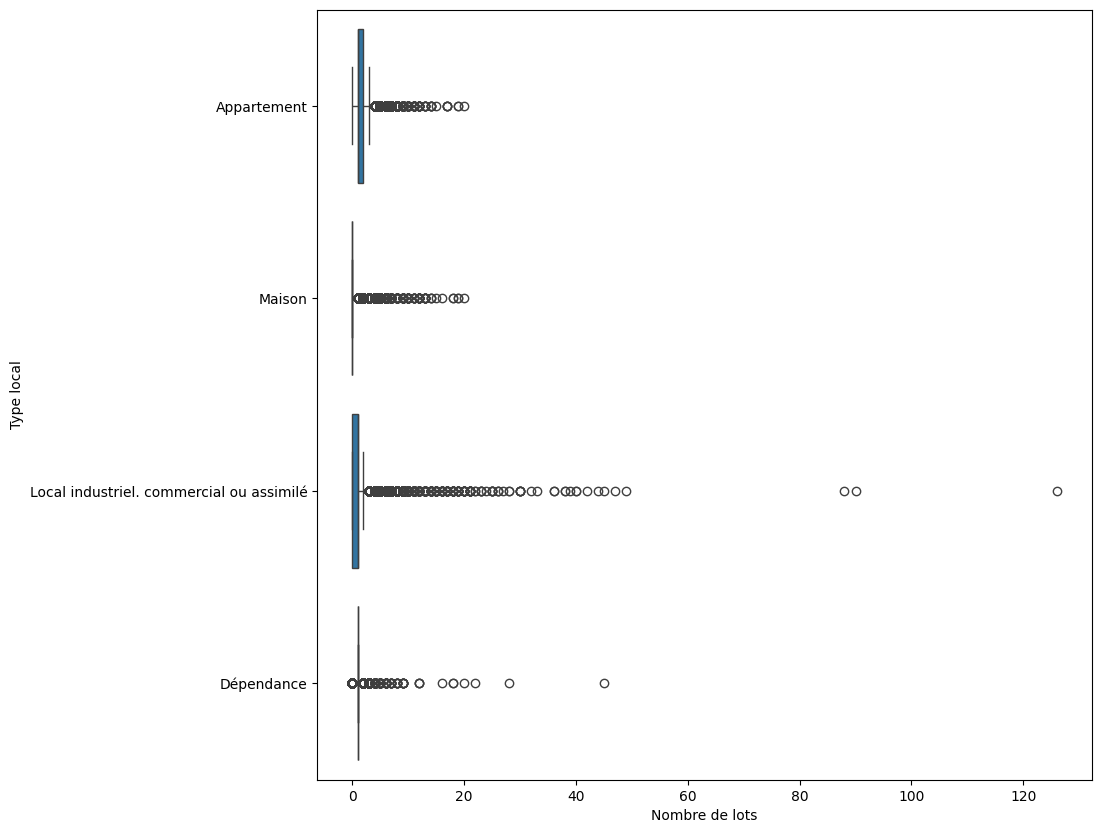

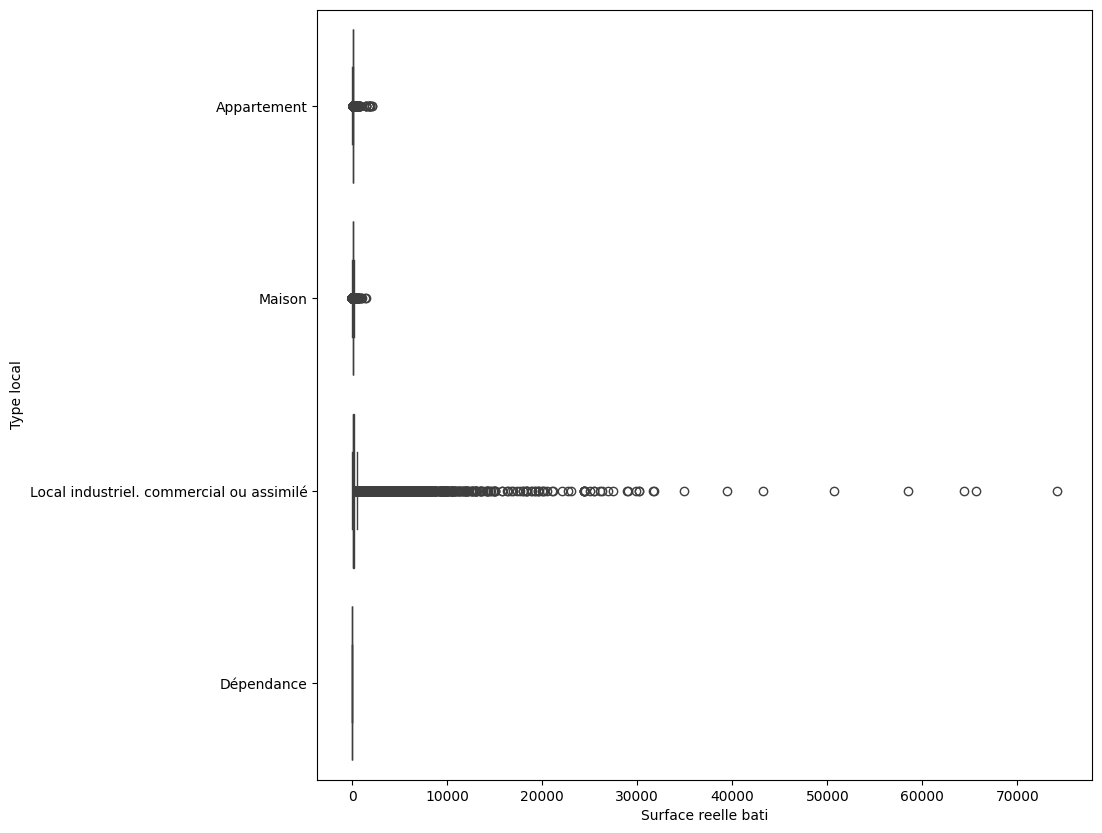

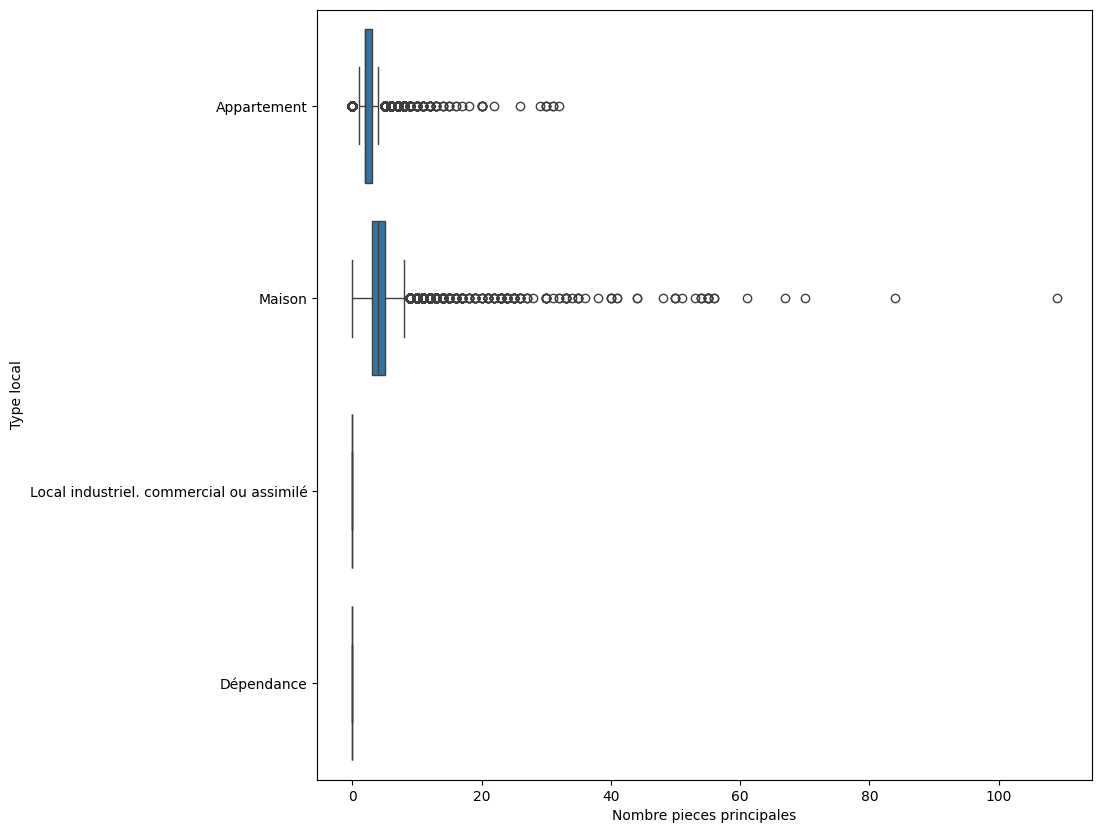

In [33]:
# Boîtes à moustaches :

# Type local en fonction de Nombre de lots :
plt.subplots(figsize=(10,10)) # Taille du boxplot
bp_lots = sns.boxplot(x="Nombre de lots", y="Type local", data=df_clas)
print(bp_lots)

# Type local en fonction de Surface reelle bati :
plt.subplots(figsize=(10,10)) # Taille du boxplot
bp_bati = sns.boxplot(x="Surface reelle bati", y="Type local", data=df_clas)
print(bp_bati)

# Type local en fonction de Nombre pieces principales :
plt.subplots(figsize=(10,10)) # Taille du boxplot
bp_pieces = sns.boxplot(x="Nombre pieces principales", y="Type local", data=df_clas)
print(bp_pieces)

Nous définissons nos variables explicatives : "Surface reelle bati", "Nombre de lots", "Nombre pieces principales" ; et notre variable cible : "Type local".

In [34]:
# Variables explicatives :
X = df_clas[['Surface reelle bati', 'Nombre de lots', 'Nombre pieces principales']]

# Variable cible :
y = df_clas['Type local']

Nous vérifions la distribution des modalités de Type local.

In [35]:
# Distribution de chaque modalité de Type local :
y.value_counts(normalize=True)

Type local
Maison                                      0.574997
Appartement                                 0.273241
Dépendance                                  0.101465
Local industriel. commercial ou assimilé    0.050297
Name: proportion, dtype: float64

Nous effectuons notre split échantillons d'apprentissage vs. échantillons test. Nous vérifions que les distributions de Type local sont bien les mêmes entre apprentissage et test.

In [36]:
# Split train-test :
from sklearn.model_selection import train_test_split
# 70% des données pour l’apprentissage
# 30% des données pour l'échantillon test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    stratify = y,
                                                    random_state = 0)

# Stratification des distributions de Type local :
print('Distribution de Type local en apprentissage :', y_train.value_counts(normalize=True))
print('Distribution de Type local en test :', y_test.value_counts(normalize=True))


Distribution de Type local en apprentissage : Type local
Maison                                      0.574997
Appartement                                 0.273241
Dépendance                                  0.101465
Local industriel. commercial ou assimilé    0.050297
Name: proportion, dtype: float64
Distribution de Type local en test : Type local
Maison                                      0.574997
Appartement                                 0.273242
Dépendance                                  0.101464
Local industriel. commercial ou assimilé    0.050297
Name: proportion, dtype: float64


# Transformation des données

Pour l'optimisation temporelle des modèles, nous avons fait le choix de remplacer les valeurs manquantes par la moyenne (pour les variables quantitatives explicatives).

Notre premier choix était de remplacer les valeurs manquantes par les kNN. Cependant, cela prenait trop de temps dans le traitement.

In [37]:
# Remplacement des NaN :

# Échantillon d'apprentissage :
for col in X_train :
    X_train[col] = X_train[col].fillna(X_train[col].mean())

# Vérification du remplacement des NaN :
print(X_train.isna().sum()) # 0 NaN

# Échantillon test :
for col in X_test :
    X_test[col] = X_test[col].fillna(X_test[col].mean())

# Vérification du remplacement des NaN :
print(X_test.isna().sum()) # 0 NaN

Surface reelle bati          0
Nombre de lots               0
Nombre pieces principales    0
dtype: int64
Surface reelle bati          0
Nombre de lots               0
Nombre pieces principales    0
dtype: int64


Nous pouvons de nouveau standardiser les variables explicatives en apprentissage et en test.

In [38]:
# Standardisation des variables :
from sklearn.preprocessing import StandardScaler

# Échantillon d'apprentissage :
Xtrain_Z = X_train
scaler = StandardScaler()
Xtrain_Z = scaler.fit_transform(Xtrain_Z)
print(Xtrain_Z) # array

# Échantillon test :
Xtest_Z = X_test
Xtest_Z = scaler.fit_transform(Xtest_Z)
print(Xtest_Z) # array

[[-0.0361858  -0.6685703  -0.01760796]
 [ 0.17120603 -0.6685703   0.51240179]
 [-0.09050271 -0.6685703   0.51240179]
 ...
 [ 0.54648649 -0.6685703   1.57242128]
 [ 0.16626813 -0.6685703   0.51240179]
 [-0.0213721  -0.6685703   0.51240179]]
[[-1.92653692e-01  4.41863234e-01 -5.48131618e-01]
 [ 5.08911135e-02 -6.79287138e-01  1.03854380e+00]
 [ 6.35836093e-04 -6.79287138e-01  5.09651997e-01]
 ...
 [-2.27445807e-01  4.41863234e-01 -1.07702343e+00]
 [-2.25589073e-02 -6.79287138e-01  1.03854380e+00]
 [-1.48273262e-02 -6.79287138e-01  5.09651997e-01]]


In [39]:
# Transformation des ndarray en dataframe :

# Train :
Xtrain_Z = pd.DataFrame(data=Xtrain_Z, columns=X.columns)
print(Xtrain_Z)

# Test :
Xtest_Z = pd.DataFrame(data=Xtest_Z, columns=X.columns)
print(Xtest_Z)

         Surface reelle bati  Nombre de lots  Nombre pieces principales
0                  -0.036186       -0.668570                  -0.017608
1                   0.171206       -0.668570                   0.512402
2                  -0.090503       -0.668570                   0.512402
3                  27.250654       -0.668570                  -1.607637
4                  -0.095441       -0.668570                  -0.017608
...                      ...             ...                        ...
1496660            -0.401590        0.434299                  -1.607637
1496661            -0.120130       -0.668570                  -0.017608
1496662             0.546486       -0.668570                   1.572421
1496663             0.166268       -0.668570                   0.512402
1496664            -0.021372       -0.668570                   0.512402

[1496665 rows x 3 columns]
        Surface reelle bati  Nombre de lots  Nombre pieces principales
0                 -0.192654        0.

Nous lançons nos modèles prédictifs de Type local.

# Arbre de décision

Nous laçons un arbre de décision pour prédire Type local.

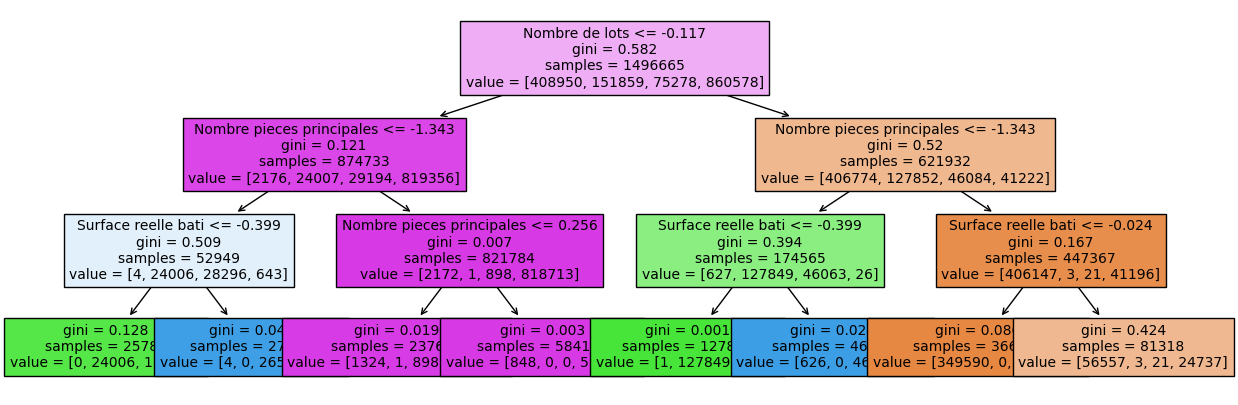

In [40]:
# Apprentissage :

# Chargement des librairies utiles :
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

# Construction de l'arbre de décision :
dtc = DecisionTreeClassifier
tree = dtc(max_depth=3, min_samples_leaf=10, min_samples_split=20, random_state=0)
tree = tree.fit(Xtrain_Z, y_train)

# Règles de l'arbre de décision
plt.figure(figsize=(15,5)) # Taille de l'affichage de l'arbre
plot_tree(tree, feature_names = list(Xtrain_Z.columns),filled=True, fontsize=10)
plt.show()

À l'aide de notre modèle, nous prédisons Type local.

In [41]:
# Prédiction :
y_predTree = tree.predict(Xtest_Z)

# Matrice de confusion en utilisant pandas.crosstab() :
mc1 = pd.crosstab(y_test,y_predTree, colnames=['pred'], rownames=['obs'], margins=True)
print('Voici la matrice de confusion entre les valeurs de Type local observées vs. prédites :')
mc1

Voici la matrice de confusion entre les valeurs de Type local observées vs. prédites :


pred,Appartement,Local industriel. commercial ou assimilé,Maison,All
obs,,,,
Appartement,174060,269,936,175265
Dépendance,0,65082,0,65082
Local industriel. commercial ou assimilé,7,31839,416,32262
Maison,17730,280,350809,368819
All,191797,97470,352161,641428


Nous évaluons ensuite notre modèle prédictif grâce à différentes métriques.

In [42]:
# Évaluation :

# Métriques - Rapport complet :
from sklearn.metrics import classification_report
report_tree = classification_report(y_test, y_predTree)
print('Rapport complet des métriques :')
report_tree

# Métriques individuelles :
from sklearn.metrics import accuracy_score, mean_squared_error, precision_score, recall_score, f1_score
# Accuracy :
acc_tree = accuracy_score(y_test, y_predTree)
print("L'accuracy est de", acc_tree) # 87%
# Precision :
precision_tree = precision_score(y_test, y_predTree, average='weighted')
print("La precision est de", precision_tree) # 84%
# Recall :
recall_tree = recall_score(y_test, y_predTree, average='weighted')
print("Le recall est de", recall_tree) # 87%
# F1 score :
f1_tree = f1_score(y_test,y_predTree,average='weighted')
print('Le f1_score est de', f1_tree) # 84%

Rapport complet des métriques :
L'accuracy est de 0.8679197041600928
La precision est de 0.8371920406261947
Le recall est de 0.8679197041600928
Le f1_score est de 0.8433845284437785


# Arbre de décision optimisé

L'optimisation des hyperparamètres de l'arbre de décision via un GridSearch avec validation croisée n'a pas de sens. En effet, des transformations de standardisation ont été opérées sur les données avant le split train-test de la cross-validation du GridSearch.

In [183]:
# Chargement des librairies utiles :
#from sklearn.model_selection import GridSearchCV
#from sklearn.model_selection import ShuffleSplit

In [184]:
# Optimisation des hyperparamètres de l'arbre :
#parameters = {'max_depth' : [1,2,3,4,5,6] ,
              #'min_samples_leaf' : [10,20,30,40],
              #'min_samples_split' : [50,100,200]}

#dtc = DecisionTreeClassifier()
#tree_op = GridSearchCV(dtc, parameters, scoring = 'accuracy' ,
                   #cv = ShuffleSplit(test_size=0.3, n_splits=1, random_state=0))
#tree_op.fit(Xtrain_Z, y_train)

# Hyperparamètres optimisés :
#print("Les paramètres du meilleur modèle sont : " + str(tree_op.best_estimator_))
# max_depth = 6
# min_samples_leaf = 10
# min_samples_split = 50

# Accuracy :
#print("Le " + str(tree_op.scorer_) + " du meilleur modèle est : " + str(tree_op.best_score_)) # 97%
# F1 score :

Les paramètres du meilleur modèle sont : DecisionTreeClassifier(max_depth=6, min_samples_leaf=10, min_samples_split=50)
Le score make_scorer(accuracy_score) du meilleur modèle est : 0.9720284791350782


In [ ]:
# Arbre de décision avec paramètres optimisés :
#plt.figure(figsize=(15,20)) # Taille de l'arbre affiché
#plot_tree(tree_op.best_estimator_,feature_names = list(Xtrain_Z.columns),filled=True, fontsize=10)
#plt.show()

In [190]:
# Prédiction :
#y_predTree_op = tree_op.predict(Xtest_Z)

# Matrice de confusion :
#mc2 = pd.crosstab(y_test,y_predTree_op, colnames=['pred'], rownames=['obs'], margins=True)
#mc2


pred,Appartement,Local industriel. commercial ou assimilé,Maison,All
obs,,,,
Appartement,174330,280,2893,177503
Dépendance,0,54995,10436,65431
Local industriel. commercial ou assimilé,8,32009,717,32734
Maison,14088,284,360060,374432
All,188426,87568,374106,650100


In [43]:
# Évaluation :

# Métriques - Rapport complet :
#report_tree_op = classification_report(y_test, y_predTree_op)
#print(report_tree_op)

# Métriques individuelles :
# Accuracy :
#acc_tree_op = accuracy_score(y_test, y_predTree_op)
#print("L'accuracy est de", acc_tree_op) # 87%
# Precision :
#precision_tree_op = precision_score(y_test, y_predTree_op, average='weighted')
#print("La precision est de", precision_tree_op) # 84%
# Recall :
#recall_tree_op = recall_score(y_test, y_predTree_op, average='weighted')
#print("Le recall est de", recall_tree_op) # 87%
# F1 score :
#f1_tree_op = f1_score(y_test,y_predTree_op,average='weighted')
#print('Le f1_score est de', f1_tree_op) # 84%

# KNeighbors Classifier (sans GridSearch)

Nous laçons ensuite un modèle KNeighbors Classifier pour prédire Type local.

In [44]:
# Apprentissage :

# Importation des librairies nécessaires :
from sklearn.neighbors import KNeighborsClassifier

# Modèle kNN classifier :
knn_model = KNeighborsClassifier(n_neighbors=82)
knn_model.fit(Xtrain_Z, y_train)

KNeighborsClassifier(n_neighbors=82)

À l'aide du modèle, nous prédisons Type local.

In [45]:
# Prédiction :
y_predknn = knn_model.predict(Xtest_Z)

# Matrice de confusion :
mc3 = pd.crosstab(y_test,y_predknn, colnames=['pred'], rownames=['obs'], margins=True)
print('Voici la matrice de confusion entre les valeurs de Type local observées vs. prédites :')
mc3

Voici la matrice de confusion entre les valeurs de Type local observées vs. prédites :


pred,Appartement,Local industriel. commercial ou assimilé,Maison,All
obs,,,,
Appartement,170934,301,4030,175265
Dépendance,0,65082,0,65082
Local industriel. commercial ou assimilé,7,32255,0,32262
Maison,12361,290,356168,368819
All,183302,97928,360198,641428


Nous évaluons notre modèle à l'aide de différentes métriques.

In [46]:
# Évaluation :

# Métriques - Rapport complet :
from sklearn.metrics import classification_report
report_knn = classification_report(y_test, y_predknn)
report_knn

# Métriques individuelles :
from sklearn.metrics import accuracy_score, mean_squared_error, precision_score, recall_score, f1_score
# Accuracy :
acc_knn = accuracy_score(y_test, y_predknn)
print("L'accuracy est de", acc_knn) # 97%
# Precision :
precision_knn = precision_score(y_test, y_predknn, average='weighted')
print("La precision est de", precision_knn) # 92%
# Recall :
recall_knn = recall_score(y_test, y_predknn, average='weighted')
print("Le recall est de", recall_knn) # 97%
# F1 score :
f1_knn = f1_score(y_test,y_predknn, average='weighted')
print('Le f1_score est de', f1_knn) # 97%

L'accuracy est de 0.87204955193724
La precision est de 0.8399354468117173
Le recall est de 0.87204955193724
Le f1_score est de 0.8472791174109171


# KNeighbors Classifier (avec GridSearch)

Le même modèle que précédemment avec optimisation des paramètres est non seulement long à lancer, mais en plus n'a pas de sens (les données ont été prélablement transformées avant le split train-test de la validation croisée du GridSearch).

In [202]:
# Fonction qui donne le nombre de combinaisons que le GridSearch va faire :
def alerteCombinaison(dictionary_param):
    from numpy import prod
    lengths = [len(v) for v in parameters.values()]
    count = prod(lengths)
    if count < 500:
        print("C'est bon tu peux envoyer l'apprentissage !")
    elif count < 1000:
        print("Tu peux lire tes mails pendant l'apprentissage !")
    elif count < 2000:
        print("Tu peux répondre à tes mails pendant l'apprentissage !")
    else:
        print("Tu peux mettre ton PC en veille et revenir demain !")

    print("Nombre de combinaison :")
    return(count)

from sklearn.metrics import make_scorer
parameters = {'n_neighbors' : np.arange(1,100,3)}
print(alerteCombinaison(parameters))

C'est bon tu peux envoyer l'apprentissage !
Nombre de combinaison :
33


In [203]:
# Apprentissage :

# Instanciation du KNeighbors Classifier :
knn = KNeighborsClassifier()

# Accuracy :
acc_knnGS = make_scorer(accuracy_score)
knn_model2 = GridSearchCV(knn, parameters, scoring = acc_knnGS,
                   cv = ShuffleSplit(test_size=0.3, n_splits=1,
                                     random_state=0), verbose=1)
knn_model2.fit(Xtrain_Z, y_train)

# Optimisation des hyperparamètres du KNeighbors Classifier :
print("Les paramètres du meilleur modèle sont : " + str(knn_model2.best_estimator_))
print("Le "  + str(knn_model2.scorer_) + " du meilleur modèle est " + str(knn_model2.best_score_))

Fitting 1 folds for each of 33 candidates, totalling 33 fits


GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=0, test_size=0.3, train_size=None),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  4,  7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49,
       52, 55, 58, 61, 64, 67, 70, 73, 76, 79, 82, 85, 88, 91, 94, 97])},
             scoring=make_scorer(accuracy_score), verbose=1)

In [204]:
# Optimisation des hyperparamètres du KNeighbors Classifier :
print("Les paramètres du meilleur modèle sont : " + str(knn_model2.best_estimator_)) # n_neighbors = 82
print("Le "  + str(knn_model2.scorer_) + " du meilleur modèle est " + str(knn_model2.best_score_)) # 97%

Les paramètres du meilleur modèle sont : KNeighborsClassifier(n_neighbors=82)
Le make_scorer(accuracy_score) du meilleur modèle est 0.9722833849737403


In [ ]:
# Apprentissage :

# F1 score :
f1_knnGS = make_scorer(f1_score, average='weighted')
knn_model3 = GridSearchCV(knn, parameters, scoring = f1_knnGS,
                   cv = ShuffleSplit(test_size=0.3, n_splits=1,
                                     random_state=0), verbose=1)
knn_model3.fit(Xtrain_Z, y_train)

# Optimisation des hyperparamètres du KNeighbors Classifier :
print("Les paramètres du meilleur modèle sont : " + str(knn_model3.best_estimator_))
print("Le "  + str(knn_model3.scorer_) + " du meilleur modèle est " + str(knn_model3.best_score_))

In [205]:
# Prédiction :
y_predknnGS = knn_model2.predict(Xtest_Z)

# Matrice de confusion :
pd.crosstab(y_test,y_predknnGS, colnames=['pred'], rownames=['obs'], margins=True)

pred,Appartement,Dépendance,Local industriel. commercial ou assimilé,Maison,All
obs,,,,,
Appartement,172628,5,295,4575,177503
Dépendance,0,65404,27,0,65431
Local industriel. commercial ou assimilé,8,733,31993,0,32734
Maison,12118,0,294,362020,374432
All,184754,66142,32609,366595,650100


In [206]:
# Évaluation :

# Métriques - Rapport complet :
from sklearn.metrics import classification_report
report_knnGS = classification_report(y_test, y_predknnGS)
print(report_knnGS)

# Métriques individuelles :
from sklearn.metrics import accuracy_score, mean_squared_error, precision_score, recall_score, f1_score
# Accuracy :
acc_knnGS = accuracy_score(y_test, y_predknnGS)
print("L'accuracy est de", acc_knnGS) # 97%

# F1 score :
f1_knnGS = f1_score(y_test,y_predknnGS,average='weighted')
print('Le f1_score est de', f1_knnGS) # 97%

                                          precision    recall  f1-score   support

                             Appartement       0.93      0.97      0.95    177503
                              Dépendance       0.99      1.00      0.99     65431
Local industriel. commercial ou assimilé       0.98      0.98      0.98     32734
                                  Maison       0.99      0.97      0.98    374432

                                accuracy                           0.97    650100
                               macro avg       0.97      0.98      0.98    650100
                            weighted avg       0.97      0.97      0.97    650100

L'accuracy est de 0.9722273496385172
Le f1_score est de 0.9723520849516789


Conclusion - Classification : Notre meilleur modèle de prédiction est le KNeighbors Classifier. Nous garderons donc les résultats de Type local de ce modèle pour prédire Valeur foncière.

# OPEN DATA

Nous avons décidé d'ajouter le nombre d'écoles et le prix moyen au m2 à nos données de base afin de prédire Valeur foncière. En effet, dans nos analyses préalables, elles enrichissent les modèles prédictifs.

# RÉGRESSION

On repart d'un dataset sans transformations préalables des données.

In [37]:
# Dataset avec Type local dans les variables explicatives :
print(df_reg.shape)
print(df_reg.columns)

(2166999, 5)
Index(['Surface reelle bati', 'Nombre de lots', 'Nombre pieces principales',
       'Type local', 'Valeur fonciere'],
      dtype='object')


On agrège notre dataset avec les open data.

In [ ]:
# Agrégation des open data au dataset des variables sélectionnées :
df_open = pd.merge(df_reg, commune, left_on='Commune', right_on='nom_commune_postal')
print(df_open.columns)
df_open = pd.merge(df_open, prix_m2, left_on='code_commune_INSEE', right_on='INSEE_COM')
print(df_open.columns)
df_open = pd.merge(df_open, niv_vie, left_on='code_commune_INSEE', right_on='Code Commune')

In [ ]:
# Drop des outliers :
print(df_test.shape)
top_10_feature_indices.append("Valeur fonciere")
for col in top_10_feature_indices:
    Q1 = df_test[col].quantile(0.25)
    Q3 = df_test[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_boop = df_test[(df_test[col] >= lower_bound) & (df_test[col] <= upper_bound)]
print(df_boop.shape)

# Échantillons d'apprentissage vs. test

Nous effectuons notre split train-test avant de lancer notre modèle prédictif. Pour cela, nous définissons d'abord nos variables explicatives (Surface réelle bâti, Nombre de lots, Nombre de pièces principales, Type local, open data) et notre variable cible (Valeur foncière).

In [38]:
# Variables explicatives :
XR = df_reg[['Surface reelle bati', 'Nombre de lots', 'Nombre pieces principales', 'Type local']]

# Variable cible :
yR = df_reg['Valeur fonciere']

In [39]:
df_citron = df_reg

In [ ]:
# Recodage de Type local :

# Importation des librairies nécessaire :
from sklearn.preprocessing import LabelEncoder

df_citron['Type local'] = LabelEncoder().fit_transform(df_reg['Type local'])
print(df_citron)

In [40]:
# Split train-test :
from sklearn.model_selection import train_test_split
# 70% des données pour l’apprentissage
# 30% des données pour l'échantillon test
XR_train, XR_test, yR_train, yR_test = train_test_split(XR, yR, test_size = 0.3, random_state = 0)

# Transformation des données

Nous pouvons de nouveau procéder aux transformations des données.

Nous inspectons d'abord les valeurs manquantes.

In [41]:
# Valeurs manquantes ?
print(XR.isna().sum())

print(yR.isna().sum())

Surface reelle bati          1415
Nombre de lots                  0
Nombre pieces principales    1415
Type local                      0
dtype: int64
0


Nous remplaçons les valeurs manquantes des variables explicatives en apprentissage et en test par leurs moyennes respectives.

In [45]:
# Remplacement des NaN :

# Échantillon d'apprentissage :
for col in XR_train :
    XR_train[col] = XR_train[col].fillna(XR_train[col].mean())

# Vérification du remplacement des NaN :
print(XR_train.isna().sum()) # 0 NaN

# Échantillon test :
for col in XR_test :
    XR_test[col] = XR_test[col].fillna(XR_test[col].mean())

# Vérification du remplacement des NaN :
print(XR_test.isna().sum()) # 0 NaN

In [ ]:
# Standardisation des variables :
from sklearn.preprocessing import StandardScaler

# Échantillon d'apprentissage :
XRtrain_Z = XR_train
scaler = StandardScaler()
XRtrain_Z = scaler.fit_transform(XRtrain_Z)
print(XRtrain_Z) # array

# Échantillon test :
XRtest_Z = XR_test
XRtest_Z = scaler.fit_transform(XRtest_Z)
print(XRtest_Z) # array

In [ ]:
# Transformation des ndarray en dataframe :

# Train :
XRtrain_Z = pd.DataFrame(data=XRtrain_Z, columns=XR.columns)
print(XRtrain_Z)

# Test :
XRtest_Z = pd.DataFrame(data=XRtest_Z, columns=XR.columns)
print(XRtest_Z)

# Régression linéaire

In [ ]:
# Importation des librairies nécessaires :
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Régression linéaire :
lr = LinearRegression()
lr.fit(XRtrain_Z, yR_train)

# Prédiction :
y_predlr = lr.predict(XRtest_Z)

# Évaluation - Racine du MSE :
np.sqrt(mean_squared_error(yR_test,y_predlr))

# Decision Tree Regressor

In [ ]:
# Importation des librairies nécessaires :
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# Decision Tree Regressor :
dtr = DecisionTreeRegressor()
dtr.fit(XRtrain_Z, yR_train)

# Prédiction :
y_pred_dtr = dtr.predict(XRtest_Z)

# Évaluation - Racine du MSE :
np.sqrt(mean_squared_error(yR_test,y_pred_dtr))

# Random Forest Regressor

In [ ]:
# Importation des librairies nécessaires :
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Random Forest Regressor :
rfr = RandomForestRegressor(n_estimators=30,max_depth=20)
rfr.fit(XRtrain_Z, yR_train)

# Prédiction :
y_predrfr = rfr.predict(XRtest_Z)

# Évaluation - Racine du MSE :
np.sqrt(mean_squared_error(yR_test, y_predrfr))

Le random forest était beaucoup trop long à lancer. Nous nous sommes donc contentés du Decision Tree Regressor, qui était notre meilleur modèle de prédiction, afin de prédire les valeurs de Valeur foncière.